In [1]:
# Importing necessary libraries
import os
import cv2
import numpy as np
import torch
import imageio
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import segmentation_models_pytorch as smp
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import functional as F
import torch.optim.lr_scheduler as lr_scheduler
from PIL import Image

   


In [2]:


# Prepare the Data
DATA_DIR = "./Data/"
x_train_dir = os.path.join(DATA_DIR, 'X_train')
y_train_dir = os.path.join(DATA_DIR, 'y_train')
x_valid_dir = os.path.join(DATA_DIR, 'X_val')
y_valid_dir = os.path.join(DATA_DIR, 'y_val')
x_test_dir = os.path.join(DATA_DIR, 'X_test')
y_test_dir = os.path.join(DATA_DIR, 'y_test')

class SegmentationDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, transform=None):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.transform = transform
        
        self.ids = os.listdir(imgs_dir)
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.imgs_dir, self.ids[idx])
        mask_path = os.path.join(self.masks_dir, self.ids[idx].replace(".jpg", ".png"))
        
        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
        mask = (mask > 127).astype(np.float32)  # Convert mask to binary 0 and 1
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'][None]
            
        return image, mask

# Define transformations
# Training transformations with augmentations
train_transform = A.Compose([
    A.Resize(256, 256),
    A.RandomRotate90(),
    A.Flip(),
    A.Transpose(),
    A.OneOf([
        A.ElasticTransform(p=0.1),
        A.GridDistortion(p=0.1),
        A.OpticalDistortion(p=0.1)
    ], p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Validation and test transformations without augmentations
valid_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Apply the transformations to the datasets
train_dataset = SegmentationDataset(x_train_dir, y_train_dir, train_transform)
valid_dataset = SegmentationDataset(x_valid_dir, y_valid_dir, valid_transform)
test_dataset = SegmentationDataset(x_test_dir, y_test_dir, valid_transform)




In [3]:
torch.cuda.is_available()

True

In [4]:
# Define the model and training specifics:

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
DECODER = 'UnetPlusPlus' 

model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=3, 
    classes=1, 
    activation=ACTIVATION
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = nn.BCELoss()




num_epochs = 100
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)


In [5]:
# Implement the metrics:
def iou_score(output, target):
    smooth = 1e-5
    # Remove single-dimension entries from the shape of an array.
    output = torch.squeeze(output)
    target = torch.squeeze(target)
    intersection = (output & target).float().sum()
    union = (output | target).float().sum()
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

    
    # Calculate intersection and union
    intersection = (output * target).sum(dim=(1, 2))
    union = (output + target).sum(dim=(1, 2)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean().item()



def get_metrics(output, target):
    output = output.squeeze().detach().cpu().numpy()
    target = target.squeeze().detach().cpu().numpy()

    output = (output > 0.5).astype(np.uint8)
    target = target.astype(np.uint8)
    
    iou = iou_score(torch.tensor(output), torch.tensor(target))
    accuracy = accuracy_score(target.ravel(), output.ravel())
    recall = recall_score(target.ravel(), output.ravel())
    precision = precision_score(target.ravel(), output.ravel())
    f_score = f1_score(target.ravel(), output.ravel())
    
    return iou, accuracy, recall, precision, f_score


In [ ]:
#  Train the model:


# For early stopping based on accuracy
best_val_loss = float('inf')
best_accuracy = 0.0
epochs_without_improvement = 0

# Define the learning rate scheduler for decreasing the learning rate after 6 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.4)

# Define the model saving path
model_path = "./UNETPLUSPLUS_best_model.pth"




# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    
    # Training phase
    train_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)



            
    # Validation phase
    model.eval()  # Set model to evaluation mode
    valid_loss = 0.0
    total_iou = total_acc = total_recall = total_precision = total_fscore = 0.0
    with torch.no_grad():
        for images, masks in valid_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            valid_loss += loss.item()

            iou, accuracy, recall, precision, f_score = get_metrics(outputs, masks)
            
            total_iou += iou
            total_acc += accuracy
            total_recall += recall
            total_precision += precision
            total_fscore += f_score

    valid_loss /= len(valid_loader)
    avg_iou = total_iou / len(valid_loader)
    avg_acc = total_acc / len(valid_loader)

    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, IoU: {avg_iou:.4f}, Acc: {avg_acc:.4f}, Recall: {total_recall/len(valid_loader):.4f}, Precision: {total_precision/len(valid_loader):.4f}, F1: {total_fscore/len(valid_loader):.4f}")

    # Check if accuracy improved
    if avg_acc > best_accuracy:
        best_accuracy = avg_acc
        torch.save(model.state_dict(), model_path)
        print("Best model saved with accuracy:", best_accuracy)
        epochs_without_improvement = 0
        
        
    else:
        epochs_without_improvement += 1

    # Early stopping based on accuracy
    if epochs_without_improvement == 50:
        print("Early stopping triggered after 50 epochs without accuracy improvement.")
        break

    # Step the scheduler (decrease the learning rate after 6 epoch)
    scheduler.step()

    
    
    


In [6]:
# After training loop
# Load the best model for inference
# Define the model saving path
model_path = "./UNETPLUSPLUS_best_model.pth"
model.load_state_dict(torch.load(model_path))

model.eval()  # Set it to evaluation mode

UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

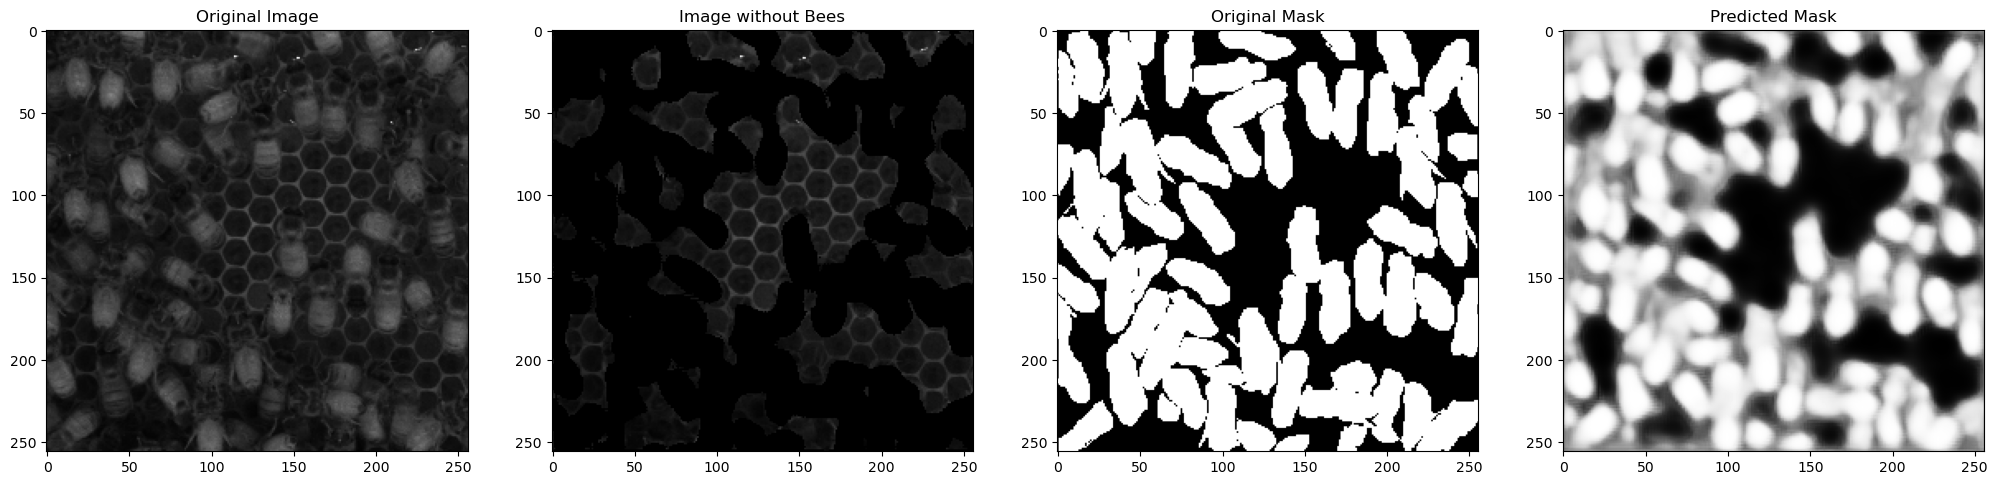

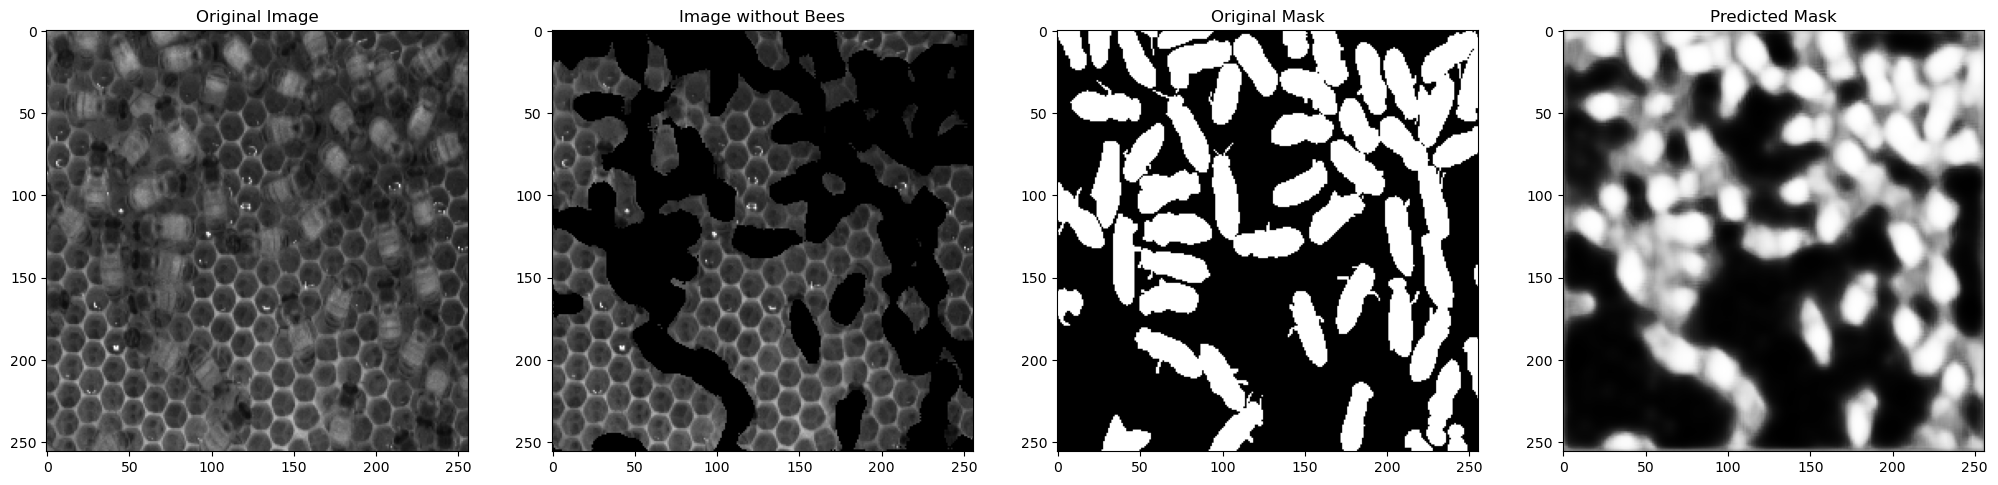

Test IoU: 0.7189314663410187
Test Accuracy: 0.8359527587890625
Test Recall: 0.8748772163186567
Test Precision: 0.8001094488165117
Test F1 Score: 0.8358211533447002


In [7]:
# Evaluate on the test set

# Denormalize function:
def denormalize(image, mean, std):
    image = image.clone().cpu().numpy()
    image = image.transpose(1, 2, 0)
    image = (image * std) + mean
    image = np.clip(image * 255, 0, 255).astype(np.uint8)  # Rescale back to [0,255]
    return image



# Function to remove bees from the image based on the predicted mask
def remove_bees(image, predicted_mask):
    # Convert the predicted mask to binary
    binary_mask = (predicted_mask > 0.5).astype(np.float32)
    inverse_mask = 1 - binary_mask
    image_without_bees = image * inverse_mask[..., None]  # Apply the inverse mask to the image
    return image_without_bees.astype(np.uint8)

# Model evaluation:
model.eval()
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Image normalization parameters used previously
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Initialize metrics
total_iou, total_acc, total_recall, total_precision, total_fscore = 0, 0, 0, 0, 0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        iou, accuracy, recall, precision, f_score = get_metrics(outputs, masks)
        total_iou += iou
        total_acc += accuracy
        total_recall += recall
        total_precision += precision
        total_fscore += f_score
        
        # Visualize the images
        fig, ax = plt.subplots(1, 4, figsize=(25, 6))
        
        denorm_img = denormalize(images[0], mean, std)
        ax[0].imshow(denorm_img)
        ax[0].set_title("Original Image")
        
        image_without_bees = remove_bees(denorm_img, outputs[0][0].cpu().numpy())
        ax[1].imshow(image_without_bees)
        ax[1].set_title("Image without Bees")
        
        ax[2].imshow(masks[0][0].cpu().numpy(), cmap="gray")
        ax[2].set_title("Original Mask")
        
        ax[3].imshow(outputs[0][0].cpu().numpy(), cmap="gray")
        ax[3].set_title("Predicted Mask")
        
        plt.show()

# Average the metrics
num_test_samples = len(test_loader)
print(f"Test IoU: {total_iou/num_test_samples}")
print(f"Test Accuracy: {total_acc/num_test_samples}")
print(f"Test Recall: {total_recall/num_test_samples}")
print(f"Test Precision: {total_precision/num_test_samples}")
print(f"Test F1 Score: {total_fscore/num_test_samples}")


In [18]:

# INFERENCE; CROPPING THE ORIGINAL IMAGE; PERFORM SEGMENTATION; REMOVE BEES; REASSEMBLE THE RESULTING IMAGE; 
                                                                       #FORM VIDEO TIMELAPSE


# Load the model and other variables outside of the function
model_path = "./UNETPLUSPLUS_best_model.pth"
model.load_state_dict(torch.load(model_path))
model.eval()  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define albumentations transformations
valid_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# --- Functions for Image Processing ---

def preprocess_image(image_np, transform):
    # Ensure the image is in float32 format
    if image_np.dtype != np.float32:
        image_np = image_np.astype(np.float32)
    
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    augmented = transform(image=image_np)
    return augmented['image']

def remove_bees_from_image(image, predicted_mask):
    """
    Remove bees from the image based on the predicted mask.

    Parameters:
    - image (numpy array): Original image of shape (H, W, 3).
    - predicted_mask (numpy array): Predicted mask of shape (H, W, 1) or (H, W).

    Returns:
    - numpy array: Image with bees removed.
    """

    # Resize the predicted mask to the size of the original image
    resized_mask = cv2.resize(predicted_mask, (image.shape[1], image.shape[0]))
    
    # Create a binary mask
    binary_mask = (resized_mask > 0.5).astype(np.float32)
    
    # Get the inverse of the mask
    inverse_mask = 1 - binary_mask
    
    # Remove bees from the image
    image_without_bees = image * inverse_mask.squeeze() 

    return image_without_bees.astype(np.uint8)


def process_image(image_path, transform):
    image = Image.open(image_path)
    width, height = image.size
    split_width = width // 3
    split_height = height // 3

    # Create an empty array to store processed parts
    processed_parts = []

    for i in range(3):
        for j in range(3):
            left = i * split_width
            upper = j * split_height
            right = left + split_width
            lower = upper + split_height
            region = image.crop((left, upper, right, lower))
            sub_image_np = np.array(region)
            sub_image_tensor = preprocess_image(sub_image_np, transform).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(sub_image_tensor)

            predicted_mask = output[0][0].cpu().numpy()
            sub_image_without_bees = remove_bees_from_image(sub_image_np, predicted_mask)
            processed_parts.append(sub_image_without_bees)

    # Reassemble the full image from processed parts (for grayscale images)
    reassembled_image = np.zeros((height, width), dtype=np.uint8)
    for i in range(3):
        for j in range(3):
            reassembled_image[j * split_height:(j + 1) * split_height,
                              i * split_width:(i + 1) * split_width] = processed_parts[i * 3 + j]

    return Image.fromarray(reassembled_image)

# --- Reassemble Images and Create Timelapse ---

#image_folder = "./Data/Without_bees_recording_14aug2023_cam1_25mm_0000"
input_folder ="/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam1/0025"
#output_video = "./Data/Video Folder/overlay_result_cummulative.mp4" 
output_video = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam1/0025.mp4"


# input_folder = "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023/0059"
# output_video = "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_cam1_video.mp4"

image_files = sorted([os.path.join(input_folder, img) for img in os.listdir(input_folder) if img.endswith('.png')])

# Initialize an empty list for storing reassembled images
reassembled_images_list = []

# Determine the resolution of the first image in the sequence
first_image = Image.open(image_files[0])
first_image_width, first_image_height = first_image.size

# Initialize the accumulated_comb array with the first image's dimensions
accumulated_comb = np.zeros((first_image_height, first_image_width), np.float32)

# Define the codec and create VideoWriter object with the first image's dimensions
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(output_video, fourcc, 2, (first_image_width, first_image_height), isColor=True)

for image_file in image_files:
    reassembled_image = process_image(image_file, valid_transform)
    image_np = np.array(reassembled_image)

    if len(image_np.shape) == 3:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

    # Ensure the image matches the dimensions of the accumulated_comb
    if image_np.shape != accumulated_comb.shape:
        image_np = cv2.resize(image_np, (first_image_width, first_image_height))

    accumulated_comb = np.maximum(accumulated_comb, image_np)
    frame_colored = cv2.cvtColor(np.uint8(accumulated_comb), cv2.COLOR_GRAY2BGR)
    out.write(frame_colored)

out.release()
print(f'The timelapse video has been saved as {output_video}')

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


The timelapse video has been saved as /home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam1/0025.mp4


In [11]:


# Load the model and set up
model_path = "./UNETPLUSPLUS_best_model.pth"
#model = # Your model architecture
model.load_state_dict(torch.load(model_path))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Albumentations transform
valid_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# --- Functions for Image Processing ---

def preprocess_image(image_np, transform):
    # Ensure the image is in float32 format
    if image_np.dtype != np.float32:
        image_np = image_np.astype(np.float32)
    
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    augmented = transform(image=image_np)
    return augmented['image']

def remove_bees_from_image(image, predicted_mask):
    """
    Remove bees from the image based on the predicted mask.

    Parameters:
    - image (numpy array): Original image of shape (H, W, 3).
    - predicted_mask (numpy array): Predicted mask of shape (H, W, 1) or (H, W).

    Returns:
    - numpy array: Image with bees removed.
    """

    # Resize the predicted mask to the size of the original image
    resized_mask = cv2.resize(predicted_mask, (image.shape[1], image.shape[0]))
    
    # Create a binary mask
    binary_mask = (resized_mask > 0.5).astype(np.float32)
    
    # Get the inverse of the mask
    inverse_mask = 1 - binary_mask
    
    # Remove bees from the image
    image_without_bees = image * inverse_mask.squeeze() 

    return image_without_bees.astype(np.uint8)


def process_image(image_path, transform):
    image = Image.open(image_path)
    width, height = image.size
    split_width = width // 3
    split_height = height // 3

    # Create an empty array to store processed parts
    processed_parts = []

    for i in range(3):
        for j in range(3):
            left = i * split_width
            upper = j * split_height
            right = left + split_width
            lower = upper + split_height
            region = image.crop((left, upper, right, lower))
            sub_image_np = np.array(region)
            sub_image_tensor = preprocess_image(sub_image_np, transform).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(sub_image_tensor)

            predicted_mask = output[0][0].cpu().numpy()
            sub_image_without_bees = remove_bees_from_image(sub_image_np, predicted_mask)
            processed_parts.append(sub_image_without_bees)

    # Reassemble the full image from processed parts (for grayscale images)
    reassembled_image = np.zeros((height, width), dtype=np.uint8)
    for i in range(3):
        for j in range(3):
            reassembled_image[j * split_height:(j + 1) * split_height,
                              i * split_width:(i + 1) * split_width] = processed_parts[i * 3 + j]

    return Image.fromarray(reassembled_image)

# Parameters
input_folder = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam1/0025"
output_video = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam1/final_video.mp4"
fps = 1
batch_size = 5
temp_video_files = []

# Process images in batches
image_files = sorted([os.path.join(input_folder, img) for img in os.listdir(input_folder) if img.endswith('.png')])
for i in range(0, len(image_files), batch_size):
    batch_files = image_files[i:i + batch_size]
    if not batch_files:
        continue

    # Process each image in the batch
    first_image = Image.open(batch_files[0])
    width, height = first_image.size
    accumulated_comb = np.zeros((height, width), np.float32)
    for image_file in batch_files:
        processed_image = process_image(image_file, valid_transform)
        image_np = np.array(processed_image)

        if len(image_np.shape) == 3:
            image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

        mask = image_np > 0
        accumulated_comb = np.maximum(accumulated_comb, image_np)

    # Convert to BGR and write the batch video
    frame_colored = cv2.cvtColor(np.uint8(accumulated_comb), cv2.COLOR_GRAY2BGR)
    temp_video_path = f"temp_batch_{i//batch_size}.mp4"
    out = cv2.VideoWriter(temp_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height), isColor=True)
    out.write(frame_colored)
    out.release()
    temp_video_files.append(temp_video_path)

# Create a file listing all the temporary video files
with open("concat_list.txt", "w") as file:
    for temp_video_file in temp_video_files:
        file.write(f"file '{temp_video_file}'\n")

# Merge temporary videos into the final video using the list file
concat_command = f"ffmpeg -f concat -safe 0 -i concat_list.txt -c copy {output_video}"
os.system(concat_command)

# Cleanup temporary files and the list file
for temp_video_file in temp_video_files:
    if os.path.exists(temp_video_file):
        os.remove(temp_video_file)
if os.path.exists("concat_list.txt"):
    os.remove("concat_list.txt")

print(f'The final timelapse video has been saved as {output_video}')

The final timelapse video has been saved as /home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam1/final_video.mp4


ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libsw

In [9]:

# Load the model and other variables outside of the function
model_path = "./UNETPLUSPLUS_best_model.pth"
model.load_state_dict(torch.load(model_path))
model.eval()  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)





# Define albumentations transformations
valid_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# --- Functions for Image Processing ---

def preprocess_image(image_np, transform):
    # Ensure the image is in float32 format
    if image_np.dtype != np.float32:
        image_np = image_np.astype(np.float32)
    
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    augmented = transform(image=image_np)
    return augmented['image']

def remove_bees_from_image(image, predicted_mask):
    """
    Remove bees from the image based on the predicted mask.

    Parameters:
    - image (numpy array): Original image of shape (H, W, 3).
    - predicted_mask (numpy array): Predicted mask of shape (H, W, 1) or (H, W).

    Returns:
    - numpy array: Image with bees removed.
    """

    # Resize the predicted mask to the size of the original image
    resized_mask = cv2.resize(predicted_mask, (image.shape[1], image.shape[0]))
    
    # Create a binary mask
    binary_mask = (resized_mask > 0.5).astype(np.float32)
    
    # Get the inverse of the mask
    inverse_mask = 1 - binary_mask
    
    # Remove bees from the image
    image_without_bees = image * inverse_mask.squeeze() 

    return image_without_bees.astype(np.uint8)


def process_image(image_path, transform):
    image = Image.open(image_path)
    width, height = image.size
    split_width = width // 3
    split_height = height // 3

    # Create an empty array to store processed parts
    processed_parts = []

    for i in range(3):
        for j in range(3):
            left = i * split_width
            upper = j * split_height
            right = left + split_width
            lower = upper + split_height
            region = image.crop((left, upper, right, lower))
            sub_image_np = np.array(region)
            sub_image_tensor = preprocess_image(sub_image_np, transform).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(sub_image_tensor)

            predicted_mask = output[0][0].cpu().numpy()
            sub_image_without_bees = remove_bees_from_image(sub_image_np, predicted_mask)
            processed_parts.append(sub_image_without_bees)

    # Reassemble the full image from processed parts (for grayscale images)
    reassembled_image = np.zeros((height, width), dtype=np.uint8)
    for i in range(3):
        for j in range(3):
            reassembled_image[j * split_height:(j + 1) * split_height,
                              i * split_width:(i + 1) * split_width] = processed_parts[i * 3 + j]

    return Image.fromarray(reassembled_image)



# def create_video_from_images(images, output_filename, frame_size, fps=2):
#     fourcc = cv2.VideoWriter_fourcc(*'MP4V')
#     out = cv2.VideoWriter(output_filename, fourcc, fps, frame_size, isColor=True)
#     for image in images:
#         out.write(image)
#     out.release()

def create_video_from_images(imageio_images, output_filename, fps=2):
    with imageio.get_writer(output_filename, fps=fps) as writer:
        for image in imageio_images:
            writer.append_data(image)


# def create_video_from_images(imageio_images, output_filename, fps=2):
#     with imageio.get_writer(output_filename, fps=fps) as writer:
#         for image in imageio_images:
#             writer.append_data(image)


def process_batch(batch_files, transform):
    processed_images = []
    for image_file in batch_files:
        reassembled_image = process_image(image_file, transform)
        image_np = np.array(reassembled_image)
        if len(image_np.shape) == 3:
            image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
        processed_images.append(image_np)
    return processed_images

# --- Reassemble Images and Create Timelapse ---

input_folder = "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/May21Cam1/0025"
output_video = "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/May21Cam1/0025.mp4"


image_files = sorted([os.path.join(input_folder, img) for img in os.listdir(input_folder) if img.endswith('.png')])
batch_size = 5

# Initialize an empty image for cumulative effect
cumulative_image = None

# Process images in batches and create the video with cumulative effect
processed_images = []

for batch_start in range(0, len(image_files), batch_size):
    batch_files = image_files[batch_start:batch_start + batch_size]
    if not batch_files:
        break

    processed_batch = process_batch(batch_files, valid_transform)

    for processed_img in processed_batch:
        # Initialize cumulative_image with the first processed image
        if cumulative_image is None:
            cumulative_image = processed_img
        else:
            # Update cumulative_image by combining it with the new processed image
            cumulative_image = cv2.addWeighted(cumulative_image, 0.5, processed_img, 0.5, 0)
        
        # Add the updated cumulative image to the list
        processed_images.append(cumulative_image.copy())

# Creating the video from processed images
create_video_from_images(processed_images, output_video)

print(f'The timelapse video has been saved as {output_video}')


# image_files = sorted([os.path.join(input_folder, img) for img in os.listdir(input_folder) if img.endswith('.png')])
# batch_size = 5



# image_files = sorted([os.path.join(input_folder, img) for img in os.listdir(input_folder) if img.endswith('.png')])
# batch_size = 5
# temp_video_files = []

# for batch_start in range(0, len(image_files), batch_size):
#     batch_files = image_files[batch_start:batch_start + batch_size]
#     if not batch_files:
#         break

#     processed_images = process_batch(batch_files, valid_transform)
#     temp_video_path = f"temp_{batch_start}.mp4"
#     first_image = Image.open(batch_files[0])
#     create_video_from_images(processed_images, temp_video_path, first_image.size)
#     temp_video_files.append(temp_video_path)

# # Transcode and standardize temporary videos
# for i, temp_video_file in enumerate(temp_video_files):
#     if os.path.exists(temp_video_file) and os.path.getsize(temp_video_file) > 0:
#         standardized_video_path = f"standardized_{i}.mp4"
#         transcode_command = f"ffmpeg -i {temp_video_file} -c:v libx264 -c:a aac -strict experimental {standardized_video_path}"
#         os.system(transcode_command)
#         os.remove(temp_video_file)  # Remove original temp file
#         temp_video_files[i] = standardized_video_path  # Update to standardized file

# # Generate the demuxer file list
# with open("temp_video_list.txt", "w") as file:
#     for temp_video_file in temp_video_files:
#         if os.path.exists(temp_video_file):
#             file.write(f"file '{temp_video_file}'\n")

# # FFmpeg command using the demuxer method
# concat_command = f"ffmpeg -f concat -safe 0 -i temp_video_list.txt -c:v libx264 -c:a aac -strict experimental \"{output_video}\""
# os.system(concat_command)

# # Clean up temporary video files and the list file
# for temp_video_file in temp_video_files:
#     if os.path.exists(temp_video_file):
#         os.remove(temp_video_file)
# if os.path.exists("temp_video_list.txt"):
#     os.remove("temp_video_list.txt")

# print(f'The timelapse video has been saved as {output_video}')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (4096, 3000) to (4096, 3008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x6a86640] Stream #0: not enough frames to estimate rate; consider increasing probesize


The timelapse video has been saved as /home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/May21Cam1/0025.mp4


In [10]:

# Load the model and other variables outside of the function
model_path = "./UNETPLUSPLUS_best_model.pth"
model.load_state_dict(torch.load(model_path))
model.eval()  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)





# Define albumentations transformations
valid_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# --- Functions for Image Processing ---

def preprocess_image(image_np, transform):
    # Ensure the image is in float32 format
    if image_np.dtype != np.float32:
        image_np = image_np.astype(np.float32)
    
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    augmented = transform(image=image_np)
    return augmented['image']

def remove_bees_from_image(image, predicted_mask):
    """
    Remove bees from the image based on the predicted mask.

    Parameters:
    - image (numpy array): Original image of shape (H, W, 3).
    - predicted_mask (numpy array): Predicted mask of shape (H, W, 1) or (H, W).

    Returns:
    - numpy array: Image with bees removed.
    """

    # Resize the predicted mask to the size of the original image
    resized_mask = cv2.resize(predicted_mask, (image.shape[1], image.shape[0]))
    
    # Create a binary mask
    binary_mask = (resized_mask > 0.5).astype(np.float32)
    
    # Get the inverse of the mask
    inverse_mask = 1 - binary_mask
    
    # Remove bees from the image
    image_without_bees = image * inverse_mask.squeeze() 

    return image_without_bees.astype(np.uint8)


def process_image(image_path, transform):
    image = Image.open(image_path)
    width, height = image.size
    split_width = width // 3
    split_height = height // 3

    # Create an empty array to store processed parts
    processed_parts = []

    for i in range(3):
        for j in range(3):
            left = i * split_width
            upper = j * split_height
            right = left + split_width
            lower = upper + split_height
            region = image.crop((left, upper, right, lower))
            sub_image_np = np.array(region)
            sub_image_tensor = preprocess_image(sub_image_np, transform).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(sub_image_tensor)

            predicted_mask = output[0][0].cpu().numpy()
            sub_image_without_bees = remove_bees_from_image(sub_image_np, predicted_mask)
            processed_parts.append(sub_image_without_bees)

    # Reassemble the full image from processed parts (for grayscale images)
    reassembled_image = np.zeros((height, width), dtype=np.uint8)
    for i in range(3):
        for j in range(3):
            reassembled_image[j * split_height:(j + 1) * split_height,
                              i * split_width:(i + 1) * split_width] = processed_parts[i * 3 + j]

    return Image.fromarray(reassembled_image)



# Cumulative approach to process images and create a timelapse video
input_folder = "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/May21Cam1/0025"
output_video = "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/May21Cam1/0025.mp4"

fps = 4

# Get all image paths
image_files = sorted([os.path.join(input_folder, img) for img in os.listdir(input_folder) if img.endswith('.png')])

# Read the first image to obtain the height and width
first_image = Image.open(image_files[0])
width, height = first_image.size
accumulated_comb = np.zeros((height, width), np.float32)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video, fourcc, fps, (width, height), isColor=True)

# Process each image
for image_file in image_files:
    processed_image = process_image(image_file, valid_transform)
    image_np = np.array(processed_image)

    # Convert to grayscale if necessary
    if len(image_np.shape) == 3:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

    mask = image_np > 0  # Create a mask for non-black pixels
    # Update the accumulated comb image: keep the max value between the accumulated image and the new image
    accumulated_comb = np.maximum(accumulated_comb, image_np)
    # Convert the accumulated image to BGR before writing it to the video
    frame_colored = cv2.cvtColor(np.uint8(accumulated_comb), cv2.COLOR_GRAY2BGR)
    out.write(frame_colored)

# Release everything when the job is finished
out.release()

print(f'The timelapse video has been saved as {output_video}')


The timelapse video has been saved as /home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/May21Cam1/0025.mp4


In [22]:


# Load the model weights
model_path = "./UNETPLUSPLUS_best_model.pth"
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)
model.eval()


# Define albumentations transformations
valid_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Functions for image processing (preprocess_image, remove_bees_from_image, process_image) 



# --- Functions for Image Processing ---

def preprocess_image(image_np, transform):
    # Ensure the image is in float32 format
    if image_np.dtype != np.float32:
        image_np = image_np.astype(np.float32)
    
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    augmented = transform(image=image_np)
    return augmented['image']

def remove_bees_from_image(image, predicted_mask):
    """
    Remove bees from the image based on the predicted mask.

    Parameters:
    - image (numpy array): Original image of shape (H, W, 3).
    - predicted_mask (numpy array): Predicted mask of shape (H, W, 1) or (H, W).

    Returns:
    - numpy array: Image with bees removed.
    """

    # Resize the predicted mask to the size of the original image
    resized_mask = cv2.resize(predicted_mask, (image.shape[1], image.shape[0]))
    
    # Create a binary mask
    binary_mask = (resized_mask > 0.5).astype(np.float32)
    
    # Get the inverse of the mask
    inverse_mask = 1 - binary_mask
    
    # Remove bees from the image
    image_without_bees = image * inverse_mask.squeeze() 

    return image_without_bees.astype(np.uint8)


def process_image(image_path, transform):
    image = Image.open(image_path)
    width, height = image.size
    split_width = width // 3
    split_height = height // 3

    # Create an empty array to store processed parts
    processed_parts = []

    for i in range(3):
        for j in range(3):
            left = i * split_width
            upper = j * split_height
            right = left + split_width
            lower = upper + split_height
            region = image.crop((left, upper, right, lower))
            sub_image_np = np.array(region)
            sub_image_tensor = preprocess_image(sub_image_np, transform).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(sub_image_tensor)

            predicted_mask = output[0][0].cpu().numpy()
            sub_image_without_bees = remove_bees_from_image(sub_image_np, predicted_mask)
            processed_parts.append(sub_image_without_bees)

    # Reassemble the full image from processed parts (for grayscale images)
    reassembled_image = np.zeros((height, width), dtype=np.uint8)
    for i in range(3):
        for j in range(3):
            reassembled_image[j * split_height:(j + 1) * split_height,
                              i * split_width:(i + 1) * split_width] = processed_parts[i * 3 + j]

    return Image.fromarray(reassembled_image)


def create_timelapse_video(image_folder, output_folder, cam_name):
    output_video = os.path.join(output_folder, f"{cam_name}_timelapse.mp4")
    image_files = sorted([os.path.join(dp, f) for dp, dn, filenames in os.walk(image_folder) for f in filenames if f.endswith('.png')])
    
    if not image_files:
        print(f"No images found in {image_folder}. Skipping video creation.")
        return

    first_image = Image.open(image_files[0])
    first_image_width, first_image_height = first_image.size
    accumulated_comb = np.zeros((first_image_height, first_image_width), np.float32)
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output_video, fourcc, 4, (first_image_width, first_image_height), isColor=True)

    for image_file in image_files:
        reassembled_image = process_image(image_file, valid_transform)
        image_np = np.array(reassembled_image)
        if len(image_np.shape) == 3:
            image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        if image_np.shape != accumulated_comb.shape:
            image_np = cv2.resize(image_np, (first_image_width, first_image_height))
        accumulated_comb = np.maximum(accumulated_comb, image_np)
        frame_colored = cv2.cvtColor(np.uint8(accumulated_comb), cv2.COLOR_GRAY2BGR)
        out.write(frame_colored)

    out.release()
    print(f'The timelapse video for {image_folder} has been saved as {output_video}')
# Main processing loop
recording_folder = "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recordings"  # Update with your actual path

for date_folder in sorted(os.listdir(recording_folder)):
    date_folder_path = os.path.join(recording_folder, date_folder)
    if not os.path.isdir(date_folder_path):
        continue

    # Create an output folder within the date folder
    output_folder = os.path.join(date_folder_path, "output")
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for cam_folder in ['cam1', 'cam2']:
        cam_folder_path = os.path.join(date_folder_path, cam_folder)
        if os.path.isdir(cam_folder_path):
            create_timelapse_video(cam_folder_path, output_folder, cam_folder)


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


OSError: unrecognized data stream contents when reading image file

In [20]:


# # Load the model and set it to evaluation mode
# model_path = "./UNETPLUSPLUS_best_model.pth"
# model = torch.load(model_path)
# model.eval()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)





# # Load the model and set it to evaluation mode
# model_path = "./UNETPLUSPLUS_best_model.pth"
# model.load_state_dict(torch.load(model_path))
# model.eval()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)




# Define albumentations transformations
valid_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])



# --- Functions for Image Processing ---

def preprocess_image(image_np, transform):
    # Ensure the image is in float32 format
    if image_np.dtype != np.float32:
        image_np = image_np.astype(np.float32)
    
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    augmented = transform(image=image_np)
    return augmented['image']

def remove_bees_from_image(image, predicted_mask):
    """
    Remove bees from the image based on the predicted mask.

    Parameters:
    - image (numpy array): Original image of shape (H, W, 3).
    - predicted_mask (numpy array): Predicted mask of shape (H, W, 1) or (H, W).

    Returns:
    - numpy array: Image with bees removed.
    """

    # Resize the predicted mask to the size of the original image
    resized_mask = cv2.resize(predicted_mask, (image.shape[1], image.shape[0]))
    
    # Create a binary mask
    binary_mask = (resized_mask > 0.5).astype(np.float32)
    
    # Get the inverse of the mask
    inverse_mask = 1 - binary_mask
    
    # Remove bees from the image
    image_without_bees = image * inverse_mask.squeeze() 

    return image_without_bees.astype(np.uint8)


def process_image(image_path, transform):
    image = Image.open(image_path)
    width, height = image.size
    split_width = width // 3
    split_height = height // 3

    # Create an empty array to store processed parts
    processed_parts = []

    for i in range(3):
        for j in range(3):
            left = i * split_width
            upper = j * split_height
            right = left + split_width
            lower = upper + split_height
            region = image.crop((left, upper, right, lower))
            sub_image_np = np.array(region)
            sub_image_tensor = preprocess_image(sub_image_np, transform).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(sub_image_tensor)

            predicted_mask = output[0][0].cpu().numpy()
            sub_image_without_bees = remove_bees_from_image(sub_image_np, predicted_mask)
            processed_parts.append(sub_image_without_bees)

    # Reassemble the full image from processed parts (for grayscale images)
    reassembled_image = np.zeros((height, width), dtype=np.uint8)
    for i in range(3):
        for j in range(3):
            reassembled_image[j * split_height:(j + 1) * split_height,
                              i * split_width:(i + 1) * split_width] = processed_parts[i * 3 + j]

    return Image.fromarray(reassembled_image)






def create_timelapse_video(image_folder, output_video):
    image_files = sorted([os.path.join(dp, f) for dp, dn, filenames in os.walk(image_folder) for f in filenames if f.endswith('.png')])
    
    if not image_files:
        print(f"No images found in {image_folder}. Skipping video creation.")
        return

    first_image = Image.open(image_files[0])
    first_image_width, first_image_height = first_image.size
    accumulated_comb = np.zeros((first_image_height, first_image_width), np.float32)
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output_video, fourcc, 4, (first_image_width, first_image_height), isColor=True)

    for image_file in image_files:
        reassembled_image = process_image(image_file, valid_transform)
        image_np = np.array(reassembled_image)
        if len(image_np.shape) == 3:
            image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        if image_np.shape != accumulated_comb.shape:
            image_np = cv2.resize(image_np, (first_image_width, first_image_height))
        accumulated_comb = np.maximum(accumulated_comb, image_np)
        frame_colored = cv2.cvtColor(np.uint8(accumulated_comb), cv2.COLOR_GRAY2BGR)
        out.write(frame_colored)

    out.release()
    print(f'The timelapse video for {image_folder} has been saved as {output_video}')

# Main processing loop
recording_folder = "/path/to/recording"  # Update with your actual path

for date_folder in sorted(os.listdir(recording_folder)):
    date_folder_path = os.path.join(recording_folder, date_folder)
    if not os.path.isdir(date_folder_path):
        continue

    for cam_folder in ['cam1', 'cam2']:
        cam_folder_path = os.path.join(date_folder_path, cam_folder)
        if os.path.isdir(cam_folder_path):
            output_video = os.path.join(cam_folder_path, f"{cam_folder}_timelapse.mp4")
            create_timelapse_video(cam_folder_path, output_video)


FileNotFoundError: [Errno 2] No such file or directory: '/path/to/recording'

In [20]:
# INFERENCE; CROPPING THE ORIGINAL IMAGE; PERFORM SEGMENTATION; REMOVE BEES; REASSEMBLE THE RESULTING IMAGE



# Load the model and other variables outside of the function
model_path = "./UNETPLUSPLUS_best_model.pth"
model.load_state_dict(torch.load(model_path))
model.eval()  # Switch the model to evaluation mode
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

#input_folder = "C:\\Users\\Emily\\OneDrive\\Desktop\\Capstone Work\\Test Crop"
#input_folder = "./recording_14aug2023_cam1_25mm_0000/"
input_folder = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam1/combineMay21Cam1"
#output_folder = "./SmallImage_without_bees/"
\\Capstone\\Data\\SmallImage_final_ouput"
final_output_folder = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam1/combinedMay21Cam1_without_bee"
# Create a dictionary to hold the sub-images for reassembly
reassembled_images = {}

def preprocess_image(image_np, transform):
    # Ensure the image is in float32 format
    if image_np.dtype != np.float32:
        image_np = image_np.astype(np.float32)
    
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    augmented = transform(image=image_np)
    return augmented['image']


def remove_bees_from_image(image, predicted_mask):
    """
    Remove bees from the image based on the predicted mask.

    Parameters:
    - image (numpy array): Original image of shape (H, W, 3).
    - predicted_mask (numpy array): Predicted mask of shape (H, W, 1) or (H, W).

    Returns:
    - numpy array: Image with bees removed.
    """

    # Resize the predicted mask to the size of the original image
    resized_mask = cv2.resize(predicted_mask, (image.shape[1], image.shape[0]))
    
    # Create a binary mask
    binary_mask = (resized_mask > 0.5).astype(np.float32)
    
    # Get the inverse of the mask
    inverse_mask = 1 - binary_mask
    
    # Remove bees from the image
    #image_without_bees = image * inverse_mask[..., None]
    image_without_bees = image * inverse_mask.squeeze() #solution to dimensions not working as needed

    return image_without_bees.astype(np.uint8)


# Modify the process_image function to implement the corrections
def process_image(image_path, reassembled_images):
    image = Image.open(image_path)
    width, height = image.size
    split_width = width // 3
    split_height = height // 3

    image_name = os.path.splitext(os.path.basename(image_path))[0]
    reassembled_images[image_name] = []

    # Define albumentations transformations outside the loop
    valid_transform = A.Compose([
        A.Resize(height=256, width=256),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    for i in range(3):
        for j in range(3):
            left = i * split_width
            upper = j * split_height
            right = left + split_width
            lower = upper + split_height
            region = image.crop((left, upper, right, lower))
            
            # Convert PIL image to numpy array for processing
            sub_image_np = np.array(region)

            # Preprocess the sub-image and add a batch dimension
            sub_image_tensor = preprocess_image(sub_image_np, valid_transform).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(sub_image_tensor)

            predicted_mask = output[0][0].cpu().numpy()

            # Removing bees based on the predicted mask
            sub_image_without_bees = remove_bees_from_image(sub_image_np, predicted_mask)

            # Append the processed sub-image to the list in memory
            reassembled_images[image_name].append(Image.fromarray(sub_image_without_bees))


# Process each image in the input folder
for root, dirs, files in os.walk(input_folder):
    for file in files:
        if file.endswith(".png") or file.endswith(".jpg"):
            input_image_path = os.path.join(root, file)
            process_image(input_image_path, reassembled_images)

# Reassemble and save the images
for image_name, sub_images in reassembled_images.items():
    first_image = sub_images[0]
    reassembled_image = Image.new("RGB", (first_image.width * 3, first_image.height * 3))

    for i in range(3):
        for j in range(3):
            reassembled_image.paste(sub_images[i * 3 + j], (i * first_image.width, j * first_image.height))

    reassembled_image.save(os.path.join(final_output_folder, f"{image_name}_reassembled.png"))

print("Processing and reassembling completed.")


Processing and reassembling completed.


In [36]:
# CUMULATIVE APPROACH FOR IMAGE TIMELAPSE VIDEO

"""
Instead of showing each frame independently, you could build up the image of the comb over time. 
This means starting with an empty image and only adding new  parts that appear in each subsequent 
frame. This way, the black regions would gradually be filled in as the comb grows.

In this script, accumulated_comb is an image that accumulates the comb structure over time.
For each new frame, it keeps the maximum pixel value between the current accumulated image and the new frame.
This way, as the comb grows, the new parts are added to the accumulated image.The black regions from the segmentation 
will not be a problem because as soon as a new piece of comb appears in that region, it will update the accumulated image.

This approach assumes that the honeycomb is always growing and that once a piece of comb is constructed, it remains in place.
If the comb can also be reduced or removed, this approach may not be accurate, and you might need a more sophisticated 
method to track changes.

"""



# Parameters
#image_folder = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/Combined_recording_05june_without_bees"
image_folder = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam1/BATCH_IMAGE_AVERAGING_MAY21"
#output_video = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/video_05june.mp4" 
output_video = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam1/Averaging_video_May21.mp4"

fps = 4

# Get all image paths
image_files = sorted([os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith('.png')])

# Read the first image to obtain the height and width
first_image = cv2.imread(image_files[0], cv2.IMREAD_GRAYSCALE)
height, width = first_image.shape
accumulated_comb = np.zeros((height, width), np.float32)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(output_video, fourcc, fps, (width, height), isColor=True)

# Process each image
for image_file in image_files:
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    mask = image > 0  # Create a mask for non-black pixels
    # Update the accumulated comb image: keep the max value between the accumulated image and the new image
    accumulated_comb = np.maximum(accumulated_comb, image)
    # Convert the accumulated image to BGR before writing it to the video
    frame_colored = cv2.cvtColor(np.uint8(accumulated_comb), cv2.COLOR_GRAY2BGR)
    out.write(frame_colored)

# Release everything when the job is finished
out.release()

print(f'The timelapse video has been saved as {output_video}')


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


The timelapse video has been saved as /home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam1/Averaging_video_May21.mp4


In [47]:
# Updated CUMULATIVE APPROACH FOR IMAGE TIMELAPSE VIDEO 


"""
The provided Python script creates a time-lapse video that shows 
the growth of a honeycomb from a sequence of images. 
It does so by progressively adding only the new visible parts of 
the comb from each image to an accumulated image. This cumulative 
image gets updated with new comb sections that haven't been captured 
in previous images. Finally, it compiles these updated images into a video, 
showing the construction of the honeycomb over time without repeating any 
sections already shown.

"""


# Parameters
#image_folder ="/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/Combined_recording_05june_without_bees" 
image_folder = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/Batch_image_averaging_05june"
output_video = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/Updated_average_video_05june.mp4"
#image_folder = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam1/BATCH_IMAGE_AVERAGING_MAY21"
#output_video = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam1/Updated_Averaging_video_May21.mp4"

fps = 1  # Frames per second for the output video

# Get all image paths and sort them
image_files = sorted([
    os.path.join(image_folder, img) for img in os.listdir(image_folder) 
    if img.endswith('.png')
])

# Read the first image to obtain the height and width
first_image = cv2.imread(image_files[0], cv2.IMREAD_GRAYSCALE)
height, width = first_image.shape

# Initialize an empty array with the same size as the images
accumulated_comb = np.zeros((height, width), np.uint8)
accumulated_mask = np.zeros((height, width), dtype=bool)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(output_video, fourcc, fps, (width, height), isColor=True)

# Process each image
for image_file in image_files:
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    
    # Create a mask for the current image where the comb is visible
    current_comb_mask = image > 0
    
    # Determine the new comb parts that have not been captured yet
    new_comb_mask = current_comb_mask & ~accumulated_mask
    
    # Update the accumulated mask
    accumulated_mask |= new_comb_mask
    
    # Update the accumulated comb image with the new comb parts
    accumulated_comb[new_comb_mask] = image[new_comb_mask]
    
    # Convert the accumulated image to BGR before writing it to the video
    frame_colored = cv2.cvtColor(accumulated_comb, cv2.COLOR_GRAY2BGR)
    out.write(frame_colored)

# Release everything when the job is finished
out.release()

print(f'The timelapse video has been saved as {output_video}')

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


The timelapse video has been saved as /home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/Updated_average_video_05june.mp4


In [14]:
# IMAGE AVERAGE OVER NON-DARK PIXELS ONLY

# Set the directory where your images are located
image_directory = "./Data/Without_bees_recording_14aug2023_cam1_25mm_0000"
image_files = [os.path.join(image_directory, f) for f in sorted(os.listdir(image_directory)) if f.endswith('.png')]

# Ensure there are at least one image
if not image_files:
    raise ValueError("No image found in the directory")

# Read the first image to get the shape info
first_image = cv2.imread(image_files[0], cv2.IMREAD_GRAYSCALE)
height, width = first_image.shape
accumulated_image = np.zeros((height, width), np.float32)
count_matrix = np.zeros((height, width), np.float32)

# Accumulate the sum of all images into the first image float matrix
for image_file in image_files:
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    mask = image > 0  # Create a mask where the pixel value is greater than 0 (not dark)
    
    # Use the mask to only accumulate non-dark pixels
    np.add(accumulated_image, image * mask, out=accumulated_image, where=mask)
    
    # Update the count matrix for averaging only where the mask is True
    np.add(count_matrix, mask, out=count_matrix, where=mask)

# Avoid division by zero in case there are pixels that were always dark
count_matrix[count_matrix == 0] = 1

# Divide the accumulated values by the count_matrix to get the average
average_image = accumulated_image / count_matrix

# Clip values to the range [0, 255] and convert to uint8
average_image = np.clip(average_image, 0, 255).astype('uint8')

# Save the average image
cv2.imwrite("./Data/Video Folder/Image_average_nobees1.png", average_image)

# # Display the result
# cv2.imshow('Average Image', average_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


True

In [29]:

# IMAGE AVERAGE OVER NON-DARK PIXELS ONLY

# Set the directory where your images are located
image_directory = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam1/0025_2"
image_files = [os.path.join(image_directory, f) for f in sorted(os.listdir(image_directory)) if f.endswith('.png')]

# Ensure there are at least one image
if not image_files:
    raise ValueError("No image found in the directory")

# Read the first image to get the shape info
first_image = cv2.imread(image_files[0], cv2.IMREAD_GRAYSCALE)
height, width = first_image.shape
accumulated_image = np.zeros((height, width), np.float32)
count_matrix = np.zeros((height, width), np.float32)

# Set a threshold value for dark pixels
dark_threshold = 5

# Accumulate the sum of all images into the first image float matrix
for image_file in image_files:
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    mask = image > dark_threshold  # Updated mask to use the dark_threshold
    
    # Use the mask to only accumulate non-dark pixels
    np.add(accumulated_image, image * mask, out=accumulated_image, where=mask)
    
    # Update the count matrix for averaging only where the mask is True
    np.add(count_matrix, mask, out=count_matrix, where=mask)

# Avoid division by zero in case there are pixels that were always dark
count_matrix[count_matrix == 0] = 1

# Divide the accumulated values by the count_matrix to get the average
average_image = accumulated_image / count_matrix

# Clip values to the range [0, 255] and convert to uint8
average_image = np.clip(average_image, 0, 255).astype('uint8')

# Save the average image
cv2.imwrite("/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam1/Image_average_nobees.png", average_image)

# # Display the result (if needed)
# cv2.imshow('Average Image', average_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


True

In [56]:
# UPDATED IMAGE AVERAGING IN BATCHES

# Function to process a batch of images and return the average
def process_batch(image_files, dark_threshold):
    first_image = cv2.imread(image_files[0], cv2.IMREAD_GRAYSCALE)
    height, width = first_image.shape
    accumulated_image = np.zeros((height, width), np.float32)
    count_matrix = np.zeros((height, width), np.float32)

    for image_file in image_files:
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        mask = image > dark_threshold

        np.add(accumulated_image, image * mask, out=accumulated_image, where=mask)
        np.add(count_matrix, mask, out=count_matrix, where=mask)

    count_matrix[count_matrix == 0] = 1
    average_image = accumulated_image / count_matrix
    average_image = np.clip(average_image, 0, 255).astype('uint8')

    return average_image

# Set the directory where your images are located
image_directory = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam2/combineMay21_without_bee"
all_image_files = [os.path.join(image_directory, f) for f in sorted(os.listdir(image_directory)) if f.endswith('.png')]

# Check if images are available
if not all_image_files:
    raise ValueError("No image found in the directory")

# Dark pixel threshold
dark_threshold = 50

# Process images in batches of 10
batch_size = 20
for i in range(0, len(all_image_files), batch_size):
    batch_files = all_image_files[i:i+batch_size]
    average_image = process_batch(batch_files, dark_threshold)

    # Save the average image for each batch
    output_filename = f"/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam2/Batch_Image_averaging_May21/Image_average_batch_{i//batch_size + 1}.png"
    cv2.imwrite(output_filename, average_image)

    # Optional: Print out progress
    print(f"Batch {i//batch_size + 1} processed and saved to {output_filename}")


Batch 1 processed and saved to /home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam2/Batch_Image_averaging_May21/Image_average_batch_1.png
Batch 2 processed and saved to /home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam2/Batch_Image_averaging_May21/Image_average_batch_2.png
Batch 3 processed and saved to /home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam2/Batch_Image_averaging_May21/Image_average_batch_3.png
Batch 4 processed and saved to /home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam2/Batch_Image_averaging_May21/Image_average_batch_4.png
Batch 5 processed and saved to /home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam2/Batch_Image_averaging_May21/Image_average_batch_5.png
Batch 6 processed and saved to /home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam2/Batch_Image_averaging_May21/Image_average_batch_6.png
Batch 7 processed and saved to /home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam2/Batch_Image_averaging_May21/Image_average_batc

In [ ]:

# IMAGE AVERAGING IN BATCHES


import os
import cv2
import numpy as np

def process_chunk(chunk_files):
    if not chunk_files:
        return None

    first_image = cv2.imread(chunk_files[0], cv2.IMREAD_GRAYSCALE)
    height, width = first_image.shape
    accumulated_image = np.zeros((height, width), np.float32)
    count_matrix = np.zeros((height, width), np.float32)

    for image_file in chunk_files:
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        mask = image > 0.9  # Create a mask where the pixel value is greater than 0 (not dark)
        np.add(accumulated_image, image * mask, out=accumulated_image, where=mask)
        np.add(count_matrix, mask, out=count_matrix, where=mask)

    count_matrix[count_matrix == 0] = 1  # Avoid division by zero
    average_image = accumulated_image / count_matrix
    return np.clip(average_image, 0, 255).astype('uint8')

# Set the directory where your images are located
image_directory = "./Data/Without_bees_recording_14aug2023_cam1_25mm_0000"
image_files = [os.path.join(image_directory, f) for f in sorted(os.listdir(image_directory)) if f.endswith('.png')]

# Process in chunks of three
for i in range(0, len(image_files), 6):
    chunk_files = image_files[i:i+6]
    average_image = process_chunk(chunk_files) 

    if average_image is not None:
        # Save each average image
        cv2.imwrite(f"./Data/Video Folder/Chunk_image_averaging/Image_average_chunk_{i//6 + 1}.png", average_image)
    else:
        print(f"No images to process in chunk starting at index {i}")

print("Processing completed. Averaged images saved.")


In [49]:


def create_timelapse(image_folder, output_video, fps, bee_threshold):
    image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png')])
    first_image = cv2.imread(image_files[0], cv2.IMREAD_GRAYSCALE)
    height, width = first_image.shape
    cumulative_image = np.zeros((height, width), np.uint8)

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output_video, fourcc, fps, (width, height), isColor=False)

    for image_file in image_files:
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        mask = image > bee_threshold  # Filter out lower intensity pixels
        updated_pixels = np.maximum(cumulative_image, image * mask)
        cumulative_image = np.where(mask, updated_pixels, cumulative_image)

        # Write frame to video
        out.write(cumulative_image)

    out.release()

# Parameters
#image_folder ="/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/Combined_recording_05june_without_bees" 
image_folder = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam1/combinedMay21Cam1_without_bee"
output_video = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam1/New_Updated_video_May21.mp4"
# image_folder = "path_to_your_images"
# output_video = "path_to_your_output_video.mp4"
fps = 2  # Frames per second
bee_threshold = 50  # Adjust this threshold based on your images

create_timelapse(image_folder, output_video, fps, bee_threshold)


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [60]:
# Best as at Dec 9

def create_timelapse(image_folder, output_video, fps, window_size):
    image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png')])
    first_image = cv2.imread(image_files[0], cv2.IMREAD_GRAYSCALE)
    height, width = first_image.shape
    cumulative_image = np.zeros((height, width), np.uint8)
    window_images = []

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output_video, fourcc, fps, (width, height), isColor=False)

    for image_file in image_files:
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

        # Update sliding window
        window_images.append(image)
        if len(window_images) > window_size:
            window_images.pop(0)

        # Calculate the comb visibility in the current window
        comb_in_window = np.any([img > 0 for img in window_images], axis=0)

        # Update the cumulative image
        new_comb = (image > 0) & ~comb_in_window
        cumulative_image[new_comb] = image[new_comb]
        cumulative_image[comb_in_window] = np.maximum(cumulative_image[comb_in_window], image[comb_in_window])

        # Write frame to video
        out.write(cumulative_image)

    out.release()

# Parameters
image_folder = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam2/Batch_Image_averaging_May21"
output_video = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam2/New_Updated_video_May21.mp4"
fps = 2  # Frames per second
window_size = 5  # Number of frames to consider for comb persistence

create_timelapse(image_folder, output_video, fps, window_size)


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [53]:
import cv2
import numpy as np
import os

def create_timelapse(image_folder, output_video, fps, window_size, smoothing_kernel_size):
    image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png')])
    first_image = cv2.imread(image_files[0], cv2.IMREAD_GRAYSCALE)
    height, width = first_image.shape
    cumulative_image = np.zeros((height, width), np.uint8)
    window_images = []

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output_video, fourcc, fps, (width, height), isColor=False)

    for image_file in image_files:
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        image = cv2.GaussianBlur(image, (smoothing_kernel_size, smoothing_kernel_size), 0)

        # Update sliding window
        window_images.append(image)
        if len(window_images) > window_size:
            window_images.pop(0)

        # Calculate the comb visibility in the current window
        comb_in_window = np.median(window_images, axis=0) > 0

        # Update the cumulative image
        new_comb = (image > 0) & ~comb_in_window
        cumulative_image[new_comb] = image[new_comb]
        cumulative_image[comb_in_window] = np.maximum(cumulative_image[comb_in_window], image[comb_in_window])

        # Write frame to video
        out.write(cumulative_image)

    out.release()

# Parameters
image_folder = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam1/combinedMay21Cam1_without_bee"
output_video = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam1/New_Updated_video_May21.mp4"
fps = 2  # Frames per second
window_size = 5  # Number of frames to consider for comb persistence
smoothing_kernel_size = 5  # Size of the Gaussian kernel for image smoothing

create_timelapse(image_folder, output_video, fps, window_size, smoothing_kernel_size)


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [ ]:
# SIDE-BY-SIDE IMAGE TIMELAPSE VIDEO

# Parameters
image_folder = "./Data/Without_bees_recording_14aug2023_cam1_25mm_0000"  # the path where your images are located
output_video = "./Data/Video Folder/overlay_result.mp4"  # the output video file with .mp4 extension
fps = 4  # frames per second in the output video

# Get all image paths
image_files = sorted([os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith('.png')])

# Read the first image to obtain the height and width
frame = cv2.imread(image_files[0], cv2.IMREAD_GRAYSCALE)
height, width = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(output_video, fourcc, fps, (width, height), isColor=True)

# Write each image to the video
for image_file in image_files:
    frame = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)  # read the image in grayscale
    frame_colored = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)  # convert to BGR format which is needed for the video
    out.write(frame_colored)  # write the frame to the video

# Release everything when the job is finished
out.release()

print(f'The timelapse video has been saved as {output_video}')


In [2]:

# Merged Different videos together

import os
from moviepy.editor import VideoFileClip, concatenate_videoclips

# Directory containing videos
video_folder = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/recording_05juneg2023_cam1_video"

# Find all MP4 files in the directory and sort them
videos = sorted(
    [os.path.join(video_folder, file) for file in os.listdir(video_folder) if file.endswith('.mp4')]
)

# Load all videos using MoviePy
clips = [VideoFileClip(video) for video in videos]

# Determine the frame rate (fps)
fps = max(clip.fps for clip in clips)  # Use the highest fps found among the clips

# Concatenate the video clips
final_clip = concatenate_videoclips(clips, method="compose")

# Specify the output file
output_video = "/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/June05_merged_video.mp4"

# Write the result to a file, ensuring the fps is set
final_clip.write_videofile(output_video, fps=fps)


Moviepy - Building video /home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/June05_merged_video.mp4.
Moviepy - Writing video /home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/June05_merged_video.mp4



Moviepy - Done !
Moviepy - video ready /home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/June05_merged_video.mp4


In [20]:
# Combine images from different folders orderly

import os
import shutil

# List of folders containing the images
source_folders = [
    "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/May21Cam1/0025",
    "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/May21Cam1/0026",
    "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/May21Cam1/0027"
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0057",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0058",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0059",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0060",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0061",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0062",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0063",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0064",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0065",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0066",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0067",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0068",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0069",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0070",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0071",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0072",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0073",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0074",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0075",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0076",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0077",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0078",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0079",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0080",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0081",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0082",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0083",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0084",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0085",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0086",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0087",
#     "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/recording_05june2023_without_bees/0088"

    
    
]

# Destination folder where all images will be copied
#destination_folder = "/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/Combined_recording_05june_without_bees"

destination_folder ="/home/ogonna/Desktop/Lenovo Laptop/Capstone/Data/May21Cam1/combineMay21Cam1"
# Ensure the destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# Initialize a counter for naming the files uniquely
file_counter = 1

for folder in source_folders:
    # List all files in the current folder and sort them
    files = sorted(os.listdir(folder))

    for file_name in files:
        # Check if it's an image file (you can add more extensions if needed)
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            source_file = os.path.join(folder, file_name)
            # Construct a unique filename for the destination folder
            dest_file = os.path.join(destination_folder, f"{file_counter:05d}_{file_name}")
            # Copy the file
            shutil.copy2(source_file, dest_file)
            file_counter += 1

print("Images have been copied to the destination folder.")


Images have been copied to the destination folder.


In [14]:
import cv2
import numpy as np
import os

# Path to the directory containing the images
folder_path = '/home/ogonna/Desktop/Lenovo_Laptop/Capstone/Data/May21Cam1/0025'

# Initialize an empty array to hold the combined honeycomb
combined_comb = None

# Loop through each image in the folder
for file_name in sorted(os.listdir(folder_path)):
    # Load the image
    image_path = os.path.join(folder_path, file_name)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Create a binary mask (white regions become True, black regions become False)
    mask = image > 0

    # If it's the first image, initialize the combined_comb array
    if combined_comb is None:
        combined_comb = np.zeros_like(mask)

    # Combine the new comb regions with the existing combined_comb
    # This is a bitwise OR operation: it adds the new comb regions to the combined_comb
    combined_comb = combined_comb | mask

# Convert the combined_comb back to a proper image format
combined_comb_image = (combined_comb * 255).astype(np.uint8)

# Save the final combined image
cv2.imwrite('combined_honeycomb.png', combined_comb_image)


True

In [17]:
current_working_directory = os.getcwd()

print(current_working_directory)

/home/ogonna/Desktop/Lenovo_Laptop/Capstone
